<a href="https://colab.research.google.com/github/Shashank-177/star_track/blob/main/Digantra_assesment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install astroquery

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 99.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.3 MB/s eta 0:00:00


1. Downloading the star catalog

In [5]:
from astroquery.vizier import Vizier
from astropy.coordinates import SkyCoord
import astropy.units as u
import pandas as pd
import numpy as np
import csv
from scipy.spatial import KDTree
from itertools import combinations
from collections import defaultdict
import matplotlib.pyplot as plt

In [6]:
ra_center = 214.958
dec_center = -47.909
half_fov_radius_x = 2.030/2
half_fov_radius_y = 1.409/2
fov_radius = np.sqrt(half_fov_radius_x**2 + half_fov_radius_y**2)

In [7]:
Vizier.ROW_LIMIT = -1

catalog_id = "I/239/hip_main"  # Hipparcos main catalog

viz = Vizier(
    columns=["HIP", "RAICRS", "DEICRS", "Vmag"],
    column_filters={"Vmag": "<15"}
)

center = SkyCoord(ra=ra_center*u.deg, dec=dec_center*u.deg, frame="icrs")

result = viz.query_region(
    center,
    radius=fov_radius * u.deg,
    catalog=catalog_id
)
df = result[0].to_pandas()
print(df)

      HIP      RAICRS     DEICRS   Vmag
0   69501  213.429480 -47.512157   9.12
1   69542  213.542005 -48.577456   7.76
2   69557  213.571524 -47.840117   8.97
3   69570  213.603815 -48.146340   8.23
4   69652  213.823356 -48.730781   9.45
5   69797  214.273191 -48.171139   8.44
6   69799  214.275933 -48.168413  10.14
7   69802  214.289320 -46.910672   7.14
8   69837  214.386704 -46.877421   9.43
9   70067  215.076256 -48.892200   9.68
10  70086  215.134823 -47.877396   9.68
11  70115  215.207932 -46.784254   7.94
12  70191  215.411074 -46.764221   9.39
13  70194  215.429832 -49.061519   9.06
14  70202  215.451389 -48.071831   8.44
15  70238  215.564117 -47.133205   8.37
16  70270  215.661333 -48.319846   6.10
17  70320  215.813994 -47.416951   6.41
18  70339  215.865404 -47.522415   9.50
19  70441  216.154252 -47.177686   7.45
20  70537  216.442844 -47.229691   9.10


In [ ]:
print(df.columns)

Index(['HIP', 'RAICRS', 'DEICRS', 'Vmag'], dtype='object')


In [8]:
df_out = df.rename(columns={
    "RAICRS": "ra_deg",
    "DEICRS": "dec_deg",
    "Vmag": "mag"
})[["ra_deg", "dec_deg", "mag"]]
print(df_out)
df_out.to_csv(
    "catalog_214.958_-47.909.csv",
    index=False
)

        ra_deg    dec_deg    mag
0   213.429480 -47.512157   9.12
1   213.542005 -48.577456   7.76
2   213.571524 -47.840117   8.97
3   213.603815 -48.146340   8.23
4   213.823356 -48.730781   9.45
5   214.273191 -48.171139   8.44
6   214.275933 -48.168413  10.14
7   214.289320 -46.910672   7.14
8   214.386704 -46.877421   9.43
9   215.076256 -48.892200   9.68
10  215.134823 -47.877396   9.68
11  215.207932 -46.784254   7.94
12  215.411074 -46.764221   9.39
13  215.429832 -49.061519   9.06
14  215.451389 -48.071831   8.44
15  215.564117 -47.133205   8.37
16  215.661333 -48.319846   6.10
17  215.813994 -47.416951   6.41
18  215.865404 -47.522415   9.50
19  216.154252 -47.177686   7.45
20  216.442844 -47.229691   9.10


Create patterns/features from the catalog to perform star matching.

In [9]:
ra_rad = np.deg2rad(df_out["ra_deg"]).to_numpy()
dec_rad = np.deg2rad(df_out["dec_deg"]).to_numpy()

df_out["ECI_x"] = np.cos(dec_rad) * np.cos(ra_rad)
df_out["ECI_y"] = np.cos(dec_rad) * np.sin(ra_rad)
df_out["ECI_z"] = np.sin(dec_rad)

# eci_vectors = np.vstack((df_out["x"], df_out["y"], df_out["z"])).T
print(df_out.columns)

Index(['ra_deg', 'dec_deg', 'mag', 'ECI_x', 'ECI_y', 'ECI_z'], dtype='object')


In [10]:
eci_vectors = np.vstack((df_out["ECI_x"], df_out["ECI_y"], df_out["ECI_z"])).T
def angular_sep(v1, v2):
    return np.arccos(
        np.clip(np.dot(v1, v2), -1.0, 1.0)
    )
tree = KDTree(eci_vectors)


In [11]:
k = 6
patterns = []
rows = []
star_ids = np.arange(len(eci_vectors))
for i, v in enumerate(eci_vectors):
    _, idx = tree.query(v, k=k)

    for j, l in combinations(idx[1:], 2):
        theta_ij = angular_sep(v, eci_vectors[j])
        theta_ik = angular_sep(v, eci_vectors[l])
        theta_jk = angular_sep(eci_vectors[j], eci_vectors[l])

        sides = np.sort([theta_ij, theta_ik, theta_jk])
        f1 = sides[0] / sides[2]
        f2 = sides[1] / sides[2]

        rows.append({
            "star_i": star_ids[i],
            "star_j": star_ids[j],
            "star_k": star_ids[l],
            "theta_ij": theta_ij,
            "theta_ik": theta_ik,
            "theta_jk": theta_jk,
            "f1": f1,
            "f2": f2
        })
df_patterns = pd.DataFrame(rows)
print(df_patterns.head())
print("Total triangle patterns:", len(df_patterns))
df_patterns.to_csv(
    "catalog_angular_triangle_patterns.csv",
    index=False
)

   star_i  star_j  star_k  theta_ij  theta_ik  theta_jk        f1        f2
0       0       2       3  0.005962  0.011255  0.005358  0.476026  0.529733
1       0       2       7  0.005962  0.014633  0.018306  0.325704  0.799344
2       0       2       6  0.005962  0.015150  0.010025  0.393570  0.661711
3       0       2       5  0.005962  0.015164  0.010026  0.393183  0.661122
4       0       3       7  0.011255  0.014633  0.023030  0.488739  0.635395
Total triangle patterns: 210


Create pattern from centroids file

In [12]:
url = "https://raw.githubusercontent.com/Shashank-177/star_track/star_centroids/star_centroids_1.csv"

df_centroid = pd.read_csv(url)

print(df_centroid.head())
print(df_centroid.columns)


   x_centroid   y_centroid  brightness
0        6432   534.823891      163588
1        5704    35.145239      250264
2        5485   667.124878      183500
3        3625  4354.805173      224968
4        3326  4189.661038      219216
Index(['x_centroid', 'y_centroid', 'brightness'], dtype='object')


In [13]:
points_raw = df_centroid[["x_centroid", "y_centroid"]].values

center = np.median(points_raw, axis=0)
points_centered = points_raw - center

scale = np.median(np.linalg.norm(points_centered, axis=1))
points_norm = points_centered / scale

k = 6
tree_img = KDTree(points_norm)

rows_img = []

for i, p in enumerate(points_norm):
    _, idx = tree_img.query(p, k=k)

    for j, l in combinations(idx[1:], 2):
        d_ij = np.linalg.norm(p - points_norm[j])
        d_ik = np.linalg.norm(p - points_norm[l])
        d_jk = np.linalg.norm(points_norm[j] - points_norm[l])

        sides = np.sort([d_ij, d_ik, d_jk])
        f1 = sides[0] / sides[2]
        f2 = sides[1] / sides[2]

        rows_img.append({
            "img_i": i,
            "img_j": j,
            "img_k": l,
            "f1": f1,
            "f2": f2
        })

df_img_patterns = pd.DataFrame(rows_img)

In [24]:
bin_size = 0.02  # feature tolerance
hash_table = defaultdict(list)

# df_catalog_patterns must already exist
# columns: star_i, star_j, star_k, f1, f2

for _, row in df_patterns.iterrows():
    bx = int(row["f1"] / bin_size)
    by = int(row["f2"] / bin_size)
    hash_table[(bx, by)].append(row)

print("Number of occupied hash bins:", len(hash_table))

Number of occupied hash bins: 96


In [25]:
matches = []

for _, img_row in df_img_patterns.iterrows():
    bx = int(img_row["f1"] / bin_size)
    by = int(img_row["f2"] / bin_size)

    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            for cat_row in hash_table.get((bx + dx, by + dy), []):

                matches.append({
                    "img_i": img_row["img_i"],
                    "img_j": img_row["img_j"],
                    "img_k": img_row["img_k"],
                    "cat_i": cat_row["star_i"],
                    "cat_j": cat_row["star_j"],
                    "cat_k": cat_row["star_k"],
                    "f1_img": img_row["f1"],
                    "f2_img": img_row["f2"],
                    "f1_cat": cat_row["f1"],
                    "f2_cat": cat_row["f2"],
                })

df_matches = pd.DataFrame(matches)
print("Triangle matches found:", len(df_matches))


Triangle matches found: 1379


In [26]:
# print(df_matches.head())
print(df_matches.columns)

Index(['img_i', 'img_j', 'img_k', 'cat_i', 'cat_j', 'cat_k', 'f1_img',
       'f2_img', 'f1_cat', 'f2_cat'],
      dtype='object')


In [27]:
votes = defaultdict(int)

for _, r in df_matches.iterrows():
    votes[(r["img_i"], r["cat_i"])] += 1
    votes[(r["img_j"], r["cat_j"])] += 1
    votes[(r["img_k"], r["cat_k"])] += 1

final_matches = {}

for (img_star, cat_star), v in votes.items():
    if img_star not in final_matches or v > final_matches[img_star][1]:
        final_matches[img_star] = (cat_star, v)

df_star_matches = pd.DataFrame([
    {"img_star": k, "cat_star": v[0], "votes": v[1]}
    for k, v in final_matches.items()
])

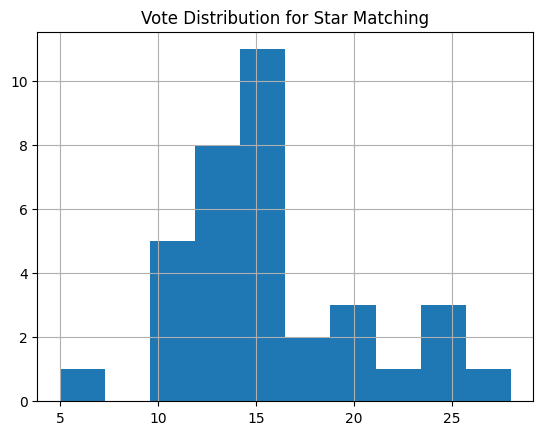

In [28]:
df_star_matches["votes"].hist()
plt.title("Vote Distribution for Star Matching")
plt.show()

In [29]:
df_img_patterns.to_csv("image_triangle_patterns.csv", index=False)
df_matches.to_csv("triangle_feature_matches.csv", index=False)
df_star_matches.to_csv("image_to_catalog_star_matches.csv", index=False)

Star id verification

In [30]:
df_verified = df_star_matches[df_star_matches["votes"] >= 3]

In [45]:
f_pixels = 980/5.5e-3
print(f_pixels)
image_width = 6576
image_height = 4384
cx = image_width / 2
cy = image_height / 2

x = df_centroid.loc[i, "x_centroid"] - cx
y = df_centroid.loc[i, "y_centroid"] - cy

178181.8181818182


In [56]:
import numpy as np

focal_length = f_pixels

B = []  # body-frame vectors

for _, r in df_verified.iterrows():
    x = df_centroid.loc[i, "x_centroid"] - cx
    y = df_centroid.loc[i, "y_centroid"] - cy

    v = np.array([x, y, focal_length])
    v = v / np.linalg.norm(v)

    B.append(v)

B = np.array(B)

In [ ]:
# R = []

# for _, r in df_verified.iterrows():
#     eci = df_out.loc[r["cat_star"], ["eci_x", "eci_y", "eci_z"]].values
#     eci = eci / np.linalg.norm(eci)
#     R.append(eci)

# R = np.array(R)

In [57]:
R = []  # inertial vectors

for _, r in df_verified.iterrows():
    ra = np.deg2rad(df_out.loc[r["cat_star"], "ra_deg"])
    dec = np.deg2rad(df_out.loc[r["cat_star"], "dec_deg"])

    v = np.array([
        np.cos(dec) * np.cos(ra),
        np.cos(dec) * np.sin(ra),
        np.sin(dec)
    ])

    R.append(v)

R = np.array(R)

In [58]:
H = B.T @ R

U, S, Vt = np.linalg.svd(H)

C = Vt.T @ U.T

if np.linalg.det(C) < 0:
    Vt[-1, :] *= -1
    C = Vt.T @ U.T

In [59]:
errors = []

for i in range(len(B)):
    b_rot = C @ B[i]
    cos_err = np.clip(np.dot(b_rot, R[i]), -1.0, 1.0)
    err = np.arccos(cos_err)
    errors.append(np.rad2deg(err))

errors = np.array(errors)

In [61]:
print("Mean angular error (deg):", errors.mean())
print("Max angular error (deg):", errors.max())

Mean angular error (deg): 0.8876485687468312
Max angular error (deg): 1.3775536136761024


In [62]:
df_final_matches = df_star_matches[df_star_matches["votes"] >= 3].copy()

In [63]:
df_final_matches = df_final_matches.merge(
    df_centroid.reset_index().rename(columns={"index": "img_star"}),
    on="img_star",
    how="left"
)

In [64]:
df_final_matches = df_final_matches.merge(
    df_out.reset_index().rename(columns={"index": "cat_star"}),
    on="cat_star",
    how="left"
)

In [65]:
df_a5 = df_final_matches[[
    "img_star",
    "cat_star",
    "x_centroid",
    "y_centroid",
    "brightness",
    "ra_deg",
    "dec_deg",
    "mag",
    "votes"
]]

In [66]:
print(df_a5.head())
print("Total matched stars:", len(df_a5))

   img_star  cat_star  x_centroid   y_centroid  brightness      ra_deg  \
0       0.0       4.0        6432   534.823891      163588  213.823356   
1       1.0       3.0        5704    35.145239      250264  213.603815   
2       2.0       4.0        5485   667.124878      183500  213.823356   
3      27.0       3.0        6254  1967.429038      250687  213.603815   
4      34.0       3.0        5217  2117.456500      184356  213.603815   

     dec_deg   mag  votes  
0 -48.730781  9.45     14  
1 -48.146340  8.23     13  
2 -48.730781  9.45     20  
3 -48.146340  8.23     28  
4 -48.146340  8.23     20  
Total matched stars: 35


In [67]:
df_a5.to_csv("matched_stars_final.csv", index=False)